In [46]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **IMPORTING LIBRARIES**

In [47]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import random
import cv2
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50

# **PREPROCESSING AND IMAGE DATA EXPLORATION**

In [48]:
IMAGE_SIZE = [224, 224]
train_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
valid_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'

In [49]:
cnt_imgs = 9 
norm_path = train_path + '/NORMAL'
pneumonia_path = train_path + '/PNEUMONIA'
norm_imgs = os.listdir(norm_path)[:cnt_imgs]
pneumonia_imgs = os.listdir(pneumonia_path)[:cnt_imgs]

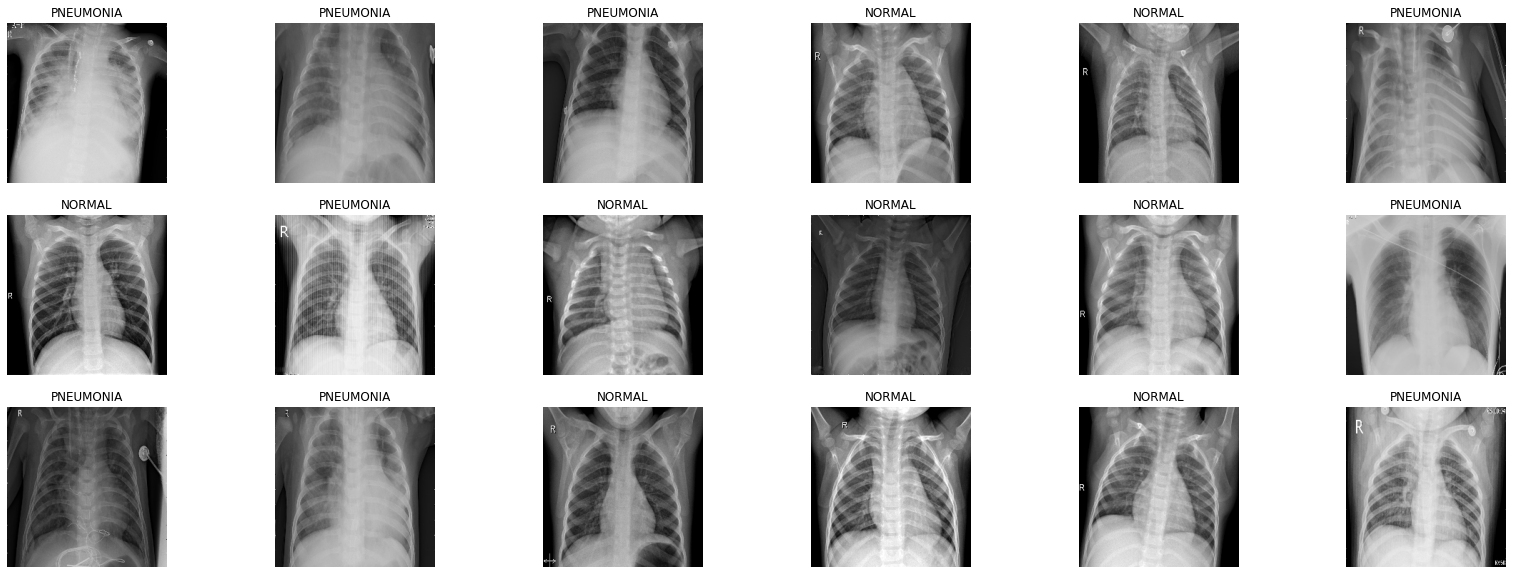

In [50]:
counter = 0
norm_imgs_path = [norm_path + '/' + i for i in norm_imgs]
pneumonia_imgs_path = [pneumonia_path + '/' + j for j in pneumonia_imgs]
all_imgs = norm_imgs_path + pneumonia_imgs_path
random.shuffle(all_imgs)

plt.figure(figsize=(28, 10))
for img_path in all_imgs:
    plt.subplot(3, 6, counter + 1)
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    label = img_path[len(train_path) + 1: img_path.rfind('/')]
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    counter += 1

In [51]:
def check_cnt_label(label: str) -> int:
    """A function that should determine the number of objects of this
    class in the specified directories"""
    cnt_object = 0
    paths = [train_path, valid_path]
    for path in paths:
        path += '/' + label
        cnt_object += len(os.listdir(path))
    return cnt_object

CNT_NORMAL = check_cnt_label('NORMAL')
CNT_PNEUMONIA = check_cnt_label('PNEUMONIA')

# **CLASS BALANCE**

In [52]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['NORMAL', 'PNEUMONIA'],
    y=[CNT_NORMAL, CNT_PNEUMONIA],
    name='Primary Product'))

fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



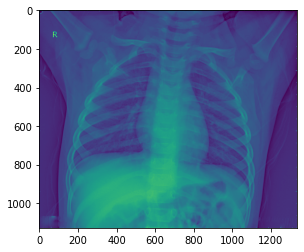

In [53]:
from PIL import ImageOps
from PIL import Image
norm_img = Image.open(train_path + '/NORMAL/' + os.listdir(train_path + '/NORMAL')[0])
pne_img = Image.open(train_path + '/PNEUMONIA/' + os.listdir(train_path + '/PNEUMONIA')[0])
def reshape_img(img):
    return img.resize(IMAGE_SIZE, Image.LANCZOS)

def convert_to_grayscale(img):
    return ImageOps.grayscale(img)
plt.imshow(reshape_img(norm_img))
plt.imshow(convert_to_grayscale(norm_img))

# **USING PRETRAINED MODELS ALONG WITH MODIFICATIONS AND HYPERPARAMETER TUNING**

In [54]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], 
              weights='imagenet', 
              include_top=False)

vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], 
              weights='imagenet', 
              include_top=False)

inception=InceptionV3(input_shape=IMAGE_SIZE + [3], 
                      weights='imagenet', 
                      include_top=False)

resnet=ResNet50(input_shape=IMAGE_SIZE + [3], 
                weights='imagenet', 
                include_top=False)

2022-12-11 18:24:46.710515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 18:24:46.822783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 18:24:46.823580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 18:24:46.824794: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 4s 0us/step


# Don't train existing weights

In [55]:

for layer in vgg16.layers:
    layer.trainable = False
    
for layer in vgg19.layers:
    layer.trainable = False
    
for layer in inception.layers:
    layer.trainable = False
    
for layer in resnet.layers:
    layer.trainable = False

In [56]:
folders = glob('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train/*')

In [58]:
x1 = Flatten()(vgg16.output)
prediction1 = Dense(len(folders), activation='softmax')(x1)
model1 = Model(inputs=vgg16.input, outputs=prediction1)

x2 = Flatten()(vgg19.output)
prediction2 = Dense(len(folders), activation='softmax')(x2)
model2 = Model(inputs=vgg19.input, outputs=prediction2)

x3 = Flatten()(inception.output)
prediction3 = Dense(len(folders), activation='softmax')(x3)
model3 = Model(inputs=inception.input, outputs=prediction3)

x4 = Flatten()(resnet.output)
prediction4 = Dense(len(folders), activation='softmax')(x4)
model4 = Model(inputs=resnet.input, outputs=prediction4)

In [59]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [60]:
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [61]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [62]:
model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [63]:
model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [64]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [65]:
training_set = train_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [66]:
test_set = test_datagen.flow_from_directory('/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [67]:
r1 = model1.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

2022-12-11 18:31:57.032253: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-11 18:31:59.377018: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 163s 942ms/step - loss: 0.1960 - accuracy: 0.9208 - val_loss: 0.2441 - val_accuracy: 0.9199
Epoch 2/10
163/163 [==============================] - 117s 716ms/step - loss: 0.1059 - accuracy: 0.9607 - val_loss: 0.2675 - val_accuracy: 0.9135
Epoch 3/10
163/163 [==============================] - 118s 726ms/step - loss: 0.1032 - accuracy: 0.9643 - val_loss: 0.5061 - val_accuracy: 0.8718
Epoch 4/10
163/163 [==============================] - 115s 705ms/step - loss: 0.0845 - accuracy: 0.9693 - val_loss: 0.2676 - val_accuracy: 0.9247
Epoch 5/10
163/163 [==============================] - 116s 710ms/step - loss: 0.0809 - accuracy: 0.9701 - val_loss: 0.4235 - val_accuracy: 0.8782
Epoch 6/10
163/163 [==============================] - 114s 698ms/step - loss: 0.0654 - accuracy: 0.9753 - val_loss: 0.3176 - val_accuracy: 0.9006
Epoch 7/10
163/163 [==============================] - 114s 697ms/step - loss: 0.0700 - accuracy: 0.9732 - val_loss: 0.4277 - val_accura

# **PLOTTING THE LOSS AND ACCURACY FOR TRAINING AND VALIDATION DATA FOR VGG16**

## Plot the loss

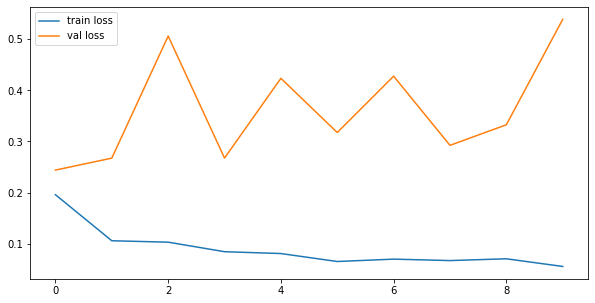

<Figure size 432x288 with 0 Axes>

In [70]:
plt.figure(figsize=(10,5))
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

## Plot the accuracy

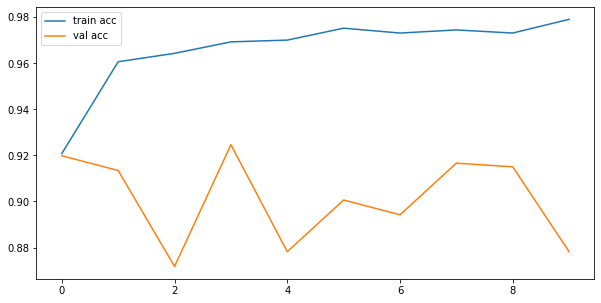

<Figure size 432x288 with 0 Axes>

In [71]:
plt.figure(figsize=(10,5))
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [72]:
loss, accuracy = model1.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

20/20 [==============================] - 7s 319ms/step - loss: 0.5388 - accuracy: 0.8782
Test accuracy : 0.8782051205635071
Test loss : 0.5387606024742126


In [73]:
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r2 = model2.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
163/163 [==============================] - 115s 702ms/step - loss: 0.2780 - accuracy: 0.9018 - val_loss: 0.2354 - val_accuracy: 0.9071
Epoch 2/10
163/163 [==============================] - 114s 702ms/step - loss: 0.1443 - accuracy: 0.9448 - val_loss: 0.5268 - val_accuracy: 0.8429
Epoch 3/10
163/163 [==============================] - 114s 702ms/step - loss: 0.1204 - accuracy: 0.9572 - val_loss: 0.6164 - val_accuracy: 0.7933
Epoch 4/10
163/163 [==============================] - 113s 696ms/step - loss: 0.1050 - accuracy: 0.9615 - val_loss: 0.4663 - val_accuracy: 0.8654
Epoch 5/10
163/163 [==============================] - 114s 702ms/step - loss: 0.1187 - accuracy: 0.9538 - val_loss: 0.2828 - val_accuracy: 0.9167
Epoch 6/10
163/163 [==============================] - 115s 703ms/step - loss: 0.1008 - accuracy: 0.9647 - val_loss: 0.2444 - val_accuracy: 0.9183
Epoch 7/10
163/163 [==============================] - 115s 704ms/step - loss: 0.0919 - accuracy: 0.9666 - val_loss: 0.3993 -

# **PLOTTING THE LOSS AND ACCURACY FOR TRAINING AND VALIDATION DATA FOR VGG19**

## plot the loss

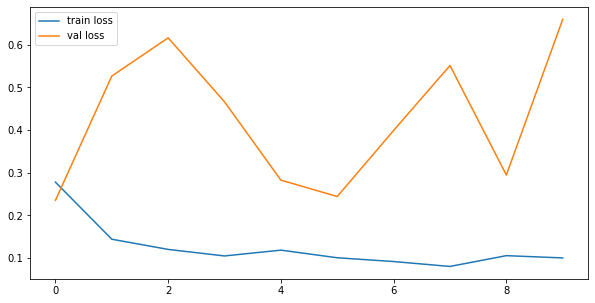

<Figure size 432x288 with 0 Axes>

In [74]:
plt.figure(figsize=(10,5))
plt.plot(r2.history['loss'], label='train loss')
plt.plot(r2.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

## plot the accuracy

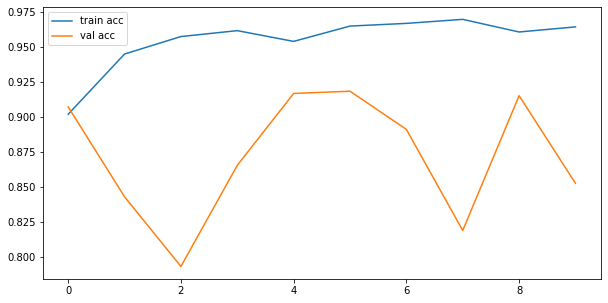

<Figure size 432x288 with 0 Axes>

In [75]:
plt.figure(figsize=(10,5))
plt.plot(r2.history['accuracy'], label='train acc')
plt.plot(r2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [76]:
loss, accuracy = model2.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

20/20 [==============================] - 6s 300ms/step - loss: 0.6597 - accuracy: 0.8526
Test accuracy : 0.8525640964508057
Test loss : 0.6597005724906921


In [77]:
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r3 = model3.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/10
163/163 [==============================] - 118s 701ms/step - loss: 0.9107 - accuracy: 0.8980 - val_loss: 1.3184 - val_accuracy: 0.8558
Epoch 2/10
163/163 [==============================] - 110s 677ms/step - loss: 0.4207 - accuracy: 0.9402 - val_loss: 0.9523 - val_accuracy: 0.8782
Epoch 3/10
163/163 [==============================] - 111s 679ms/step - loss: 0.8167 - accuracy: 0.9260 - val_loss: 1.7834 - val_accuracy: 0.8814
Epoch 4/10
163/163 [==============================] - 112s 684ms/step - loss: 0.8435 - accuracy: 0.9362 - val_loss: 3.1421 - val_accuracy: 0.8285
Epoch 5/10
163/163 [==============================] - 112s 688ms/step - loss: 0.5511 - accuracy: 0.9503 - val_loss: 2.3854 - val_accuracy: 0.8606
Epoch 6/10
163/163 [==============================] - 112s 685ms/step - loss: 0.5223 - accuracy: 0.9457 - val_loss: 1.6121 - val_accuracy: 0.8718
Epoch 7/10
163/163 [==============================] - 112s 687ms/step - loss: 0.4214 - accuracy: 0.9599 - val_loss: 1.6163 -

# **PLOTTING THE LOSS AND ACCURACY FOR TRAINING AND VALIDATION DATA FOR INCEPTIONNET**

## plot the loss

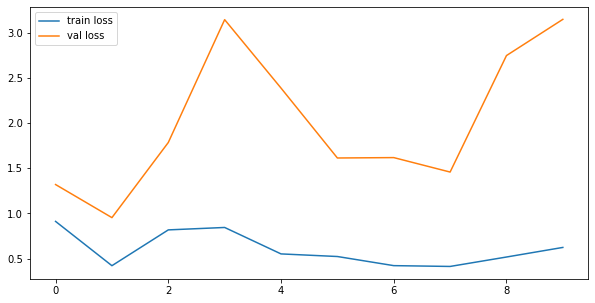

<Figure size 432x288 with 0 Axes>

In [78]:
plt.figure(figsize=(10,5))
plt.plot(r3.history['loss'], label='train loss')
plt.plot(r3.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

## plot the accuracy

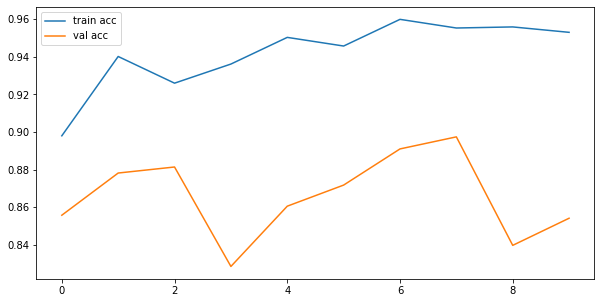

<Figure size 432x288 with 0 Axes>

In [79]:
plt.figure(figsize=(10,5))
plt.plot(r3.history['accuracy'], label='train acc')
plt.plot(r3.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [82]:
loss, accuracy = model3.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

20/20 [==============================] - 6s 301ms/step - loss: 3.1455 - accuracy: 0.8542
Test accuracy : 0.8541666865348816
Test loss : 3.145458221435547


In [83]:
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r4 = model4.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
163/163 [==============================] - 119s 713ms/step - loss: 0.9330 - accuracy: 0.8137 - val_loss: 0.4736 - val_accuracy: 0.7933
Epoch 2/10
163/163 [==============================] - 113s 691ms/step - loss: 0.3059 - accuracy: 0.8737 - val_loss: 0.3486 - val_accuracy: 0.8526
Epoch 3/10
163/163 [==============================] - 112s 689ms/step - loss: 0.2766 - accuracy: 0.8871 - val_loss: 0.3546 - val_accuracy: 0.8526
Epoch 4/10
163/163 [==============================] - 113s 692ms/step - loss: 0.2647 - accuracy: 0.8944 - val_loss: 0.3562 - val_accuracy: 0.8590
Epoch 5/10
163/163 [==============================] - 113s 691ms/step - loss: 0.3260 - accuracy: 0.8740 - val_loss: 0.4361 - val_accuracy: 0.8413
Epoch 6/10
163/163 [==============================] - 112s 688ms/step - loss: 0.3192 - accuracy: 0.8819 - val_loss: 0.3103 - val_accuracy: 0.8734
Epoch 7/10
163/163 [==============================] - 113s 691ms/step - loss: 0.2587 - accuracy: 0.8999 - val_loss: 0.3059 -

# **PLOTTING THE LOSS AND ACCURACY FOR TRAINING AND VALIDATION DATA FOR RESNET**

## plot the loss

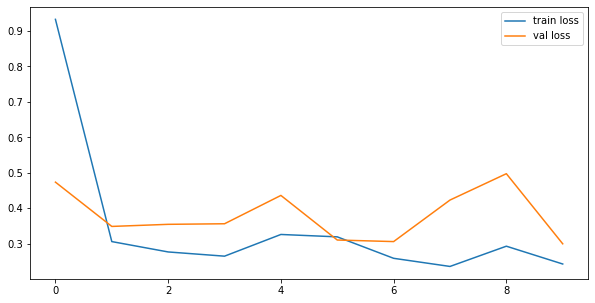

<Figure size 432x288 with 0 Axes>

In [84]:
plt.figure(figsize=(10,5))
plt.plot(r4.history['loss'], label='train loss')
plt.plot(r4.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

## plot the accuracy

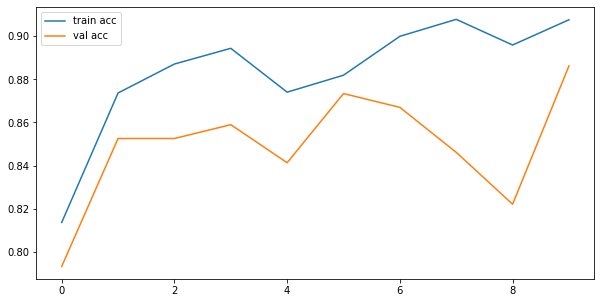

<Figure size 432x288 with 0 Axes>

In [85]:
plt.figure(figsize=(10,5))
plt.plot(r4.history['accuracy'], label='train acc')
plt.plot(r4.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [86]:
loss, accuracy = model4.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test loss :', loss)

20/20 [==============================] - 6s 290ms/step - loss: 0.2996 - accuracy: 0.8862
Test accuracy : 0.8862179517745972
Test loss : 0.2996063828468323


# **`We find that VGG19 gives the best results and hence we trin the model on 50 epochs`**

In [87]:
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r2 = model2.fit(
  training_set,
  epochs=50,
  steps_per_epoch=len(training_set),
)

Epoch 1/50
163/163 [==============================] - 107s 651ms/step - loss: 0.1139 - accuracy: 0.9624
Epoch 2/50
163/163 [==============================] - 107s 655ms/step - loss: 0.1008 - accuracy: 0.9666
Epoch 3/50
163/163 [==============================] - 107s 658ms/step - loss: 0.0787 - accuracy: 0.9730
Epoch 4/50
163/163 [==============================] - 107s 658ms/step - loss: 0.1146 - accuracy: 0.9653
Epoch 5/50
163/163 [==============================] - 106s 653ms/step - loss: 0.1103 - accuracy: 0.9645
Epoch 6/50
163/163 [==============================] - 106s 649ms/step - loss: 0.0771 - accuracy: 0.9749
Epoch 7/50
163/163 [==============================] - 107s 653ms/step - loss: 0.0646 - accuracy: 0.9768
Epoch 8/50
163/163 [==============================] - 108s 664ms/step - loss: 0.0732 - accuracy: 0.9745
Epoch 9/50
163/163 [==============================] - 108s 660ms/step - loss: 0.0725 - accuracy: 0.9749
Epoch 10/50
163/163 [==============================] - 108s 658m

# **PLOTTING FINAL MODEL LOSS AND ACCURACY FOR TRAINING AND VALIDATION DATA FOR VGG19**

## plot the loss

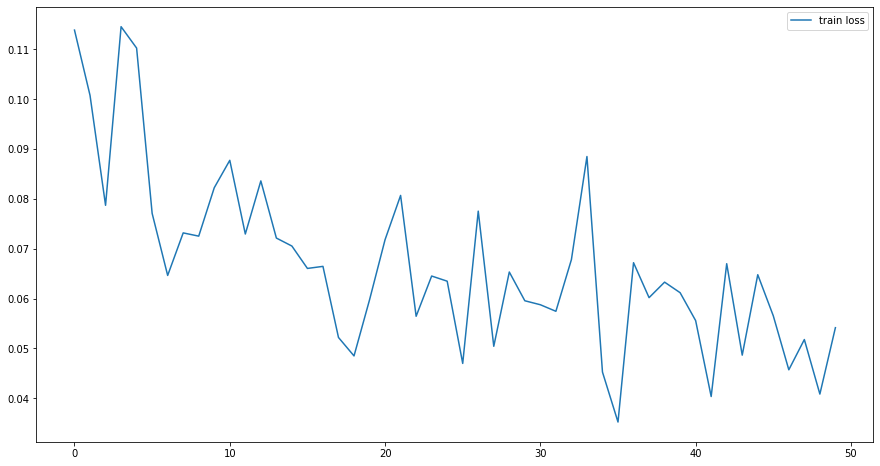

<Figure size 432x288 with 0 Axes>

In [88]:
plt.figure(figsize=(15,8))
plt.plot(r2.history['loss'], label='train loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.png')

## plot the accuracy

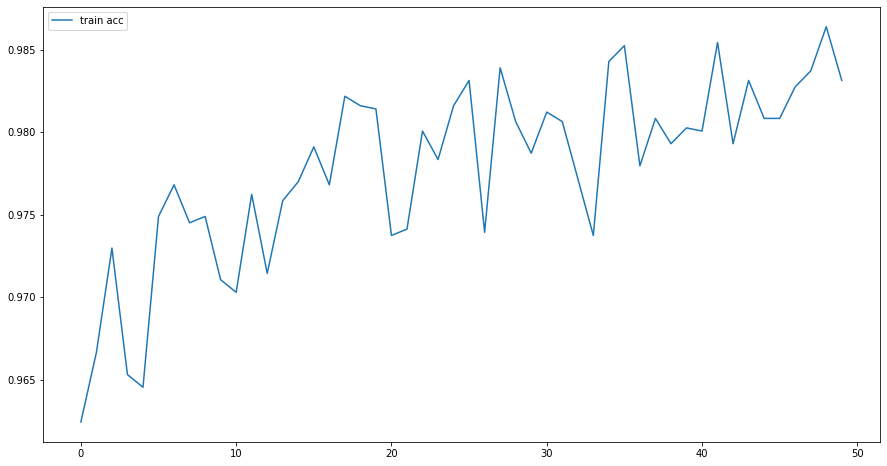

<Figure size 432x288 with 0 Axes>

In [89]:
plt.figure(figsize=(15,8))
plt.plot(r2.history['accuracy'], label='train acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc.png')

In [90]:
loss, accuracy = model2.evaluate(test_set)
print('Test accuracy :', accuracy)
print('Test Loss :', loss)

20/20 [==============================] - 7s 320ms/step - loss: 0.7223 - accuracy: 0.9038
Test accuracy : 0.9038461446762085
Test Loss : 0.7222741842269897


# **SAVING THE FINAL MODEL**

In [91]:
import tensorflow as tf
from keras.models import load_model
model2.save('model_vgg19_v1.h5')

In [1]:
# import os 
# model.save(f"/kaggle/working/v3")